TensorFlow 2.0的一個重大變格在於預設模式為Eager Execution，這意味著我們不需要一定要在session的scope才能夠計算，但也不代表一定要像舊版本一樣的定義靜態圖才能使用靜態圖，在TensorFlow 2.0中提供`@tf.function`可以快速的達到這個需求。

In [1]:
import tensorflow as tf
import numpy as np

In [2]:
tf.__version__

'2.0.0'

接著下載MNIST資料集，在這之前先設置一個簡單的回傳資料的類別

In [3]:
class Data_Loader:
    def __init__(self):
        mnist = tf.keras.datasets.mnist
        (self.x_train, self.y_train), (self.x_test, self.y_test) = mnist.load_data()
        self.x_train = self.x_train = np.expand_dims(self.x_train / 255., -1)
        self.x_test = self.x_test = np.expand_dims(self.x_test / 255., -1)
    
    def batch_data(self, t_type='train', batch_size=32):        
        if t_type == 'train':
            index = np.random.randint(0, self.x_train.shape[0], batch_size)
            return self.x_train[index], self.y_train[index]
        elif t_type == 'test':
            index = np.random.randint(0, self.x_test.shape[0], batch_size)        
            return self.x_test[index], self.y_test[index]

簡單列印幾張照片來確認

In [4]:
data_loader = Data_Loader()

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

隨機取得10個索引

In [6]:
_x, y = data_loader.batch_data(batch_size=10)

In [7]:
y

array([9, 8, 4, 1, 4, 3, 5, 6, 0, 9], dtype=uint8)

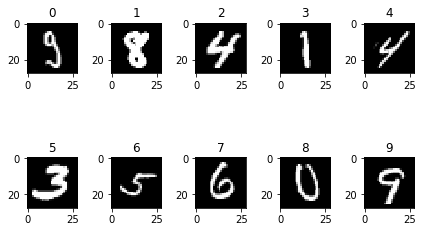

In [8]:
for idx in range(10):
    ax = plt.subplot(2, 5,idx+1)
    ax.imshow(_x[idx, :, :, 0], cmap='gray')
    plt.title(idx)    

plt.tight_layout()
plt.show()

指定硬體資源，相關可[參考](https://hackmd.io/@shaoeChen/ryWIV4vkL)

In [9]:
gpus = tf.config.experimental.list_physical_devices(device_type='GPU')

In [10]:
gpus 

[PhysicalDevice(name=u'/physical_device:GPU:0', device_type=u'GPU'),
 PhysicalDevice(name=u'/physical_device:GPU:1', device_type=u'GPU')]

In [11]:
tf.config.experimental.set_visible_devices(devices=gpus[1], device_type='GPU')

In [12]:
tf.config.experimental.set_memory_growth(device=gpus[1], enable=True)

透過繼承`tf.keras.Model`來建構class

利用`tf.keras.Model`建構類別的時候要注意三點：
1. 初始化一定要繼承父類
2. 是`call`不是`__call__`
3. 不能使用`self.output`，因為這已經被用了

In [13]:
class LeNet5(tf.keras.Model):
    def __init__(self):
        # 一定要繼承父類的__init__才能使用父類相關的method與attribute
        super(LeNet5, self).__init__()
#         self.input = tf.keras.layers.InputLayer(input_shape=(28, 28, 1))
        self.conv1 = tf.keras.layers.Conv2D(filters=6, kernel_size=(5, 5), padding='valid', activation='tanh')
        self.maxpool1 = tf.keras.layers.MaxPool2D(pool_size=(2, 2))
        self.conv2 = tf.keras.layers.Conv2D(filters=16, kernel_size=(5, 5), padding='valid', activation='tanh')
        self.maxpool2 = tf.keras.layers.MaxPool2D(pool_size=(2, 2))
        self.flatten = tf.keras.layers.Flatten()
        self.dense1 = tf.keras.layers.Dense(120, activation='tanh')
        self.dense2 = tf.keras.layers.Dense(84, activation='tanh')
        self.pred_y = tf.keras.layers.Dense(10, activation='softmax')
    def call(self, x):
        x = self.conv1(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.maxpool2(x)
        x = self.flatten(x)
        x = self.dense1(x)
        x = self.dense2(x)
        return self.pred_y(x)

確認模型

In [14]:
model = LeNet5()

編譯模型

這邊不再使用原始keras所提供的高階api-`model.compile`、`model.fit`做訓練，而是自定義細部，下面定義方式取自官方的入門範例，並自行修改

因為我們並未將label轉one-hot encoder，因此必需使用`sparse_categorical_crossentropy`做為loss function

首先定義最佳化方式、損失函數

In [15]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam()

定義度量方式

In [16]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy('train_accuracy')

利用`tf.GradientTape`訓練模型

In [17]:
def train_step(x, y):
    with tf.GradientTape() as tape:
        # 計算feedforward得到output
        predictions = model(x)
        # 計算實際與模型output的loss
        loss = loss_object(y, predictions)
    
    # 計算可訓練參數對損失函數的梯度
    gradients = tape.gradient(loss, model.trainable_variables)
    # 利用得到的梯度來更新參數
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    train_loss(loss)
    train_accuracy(y, predictions)

In [18]:
%%time
# 迭代迴圈
for epoch in range(5):
    # 批次取資料迴圈
    for batch in range(int(60000/128)):        
        x, y = data_loader.batch_data(t_type='train', batch_size=128)
        train_step(x, y)
        


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

CPU times: user 35.2 s, sys: 1.74 s, total: 37 s
Wall time: 30.6 s


現在，調整上面的函數，加入裝飾器`@tf.function`之後再重新測試一次

In [17]:
@tf.function
def train_step(x, y):
    with tf.GradientTape() as tape:
        # 計算feedforward得到output
        predictions = model(x)
        # 計算實際與模型output的loss
        loss = loss_object(y, predictions)
    
    # 計算可訓練參數對損失函數的梯度
    gradients = tape.gradient(loss, model.trainable_variables)
    # 利用得到的梯度來更新參數
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    train_loss(loss)
    train_accuracy(y, predictions)

In [18]:
%%time
# 迭代迴圈
for epoch in range(5):
    # 批次取資料迴圈
    for batch in range(int(60000/128)):        
        x, y = data_loader.batch_data(t_type='train', batch_size=128)
        train_step(x, y)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

CPU times: user 10.3 s, sys: 1.07 s, total: 11.4 s
Wall time: 9.15 s


轉為靜態圖之後的執行效率確實比Eager Execution還來的快吧。設置的方式也很簡單，只需要在求導的函數上加入裝飾器即可，其餘部份都沒有變更，相同方式也適用於其它的建模方式(如，繼承`tf.keras.Model`、Sequential、Function)

那究竟`@tf.function`做了什麼?它在第一次被呼叫的時候做了幾件事：  
1. 每個`tf.`的方法都定義了計算節點，但沒有實質的計算
2. 透過AutoGraph將函數內的Python控制流程表達式轉為TensorFlow計算圖中的對應節點，舉例來說，`while, for`變為`tf.while`，而`if`則變為`tf.cond`
3. 基於上面兩個步驟，建立函數內程式碼的計算圖表示，為了確保圖的計算順序，圖中會自動加入`tf.control_dependcies`節點
4. 執行一次計算圖
5. 基於函數名稱與函數參數的類型生成一個hash value，將建立的計算圖寫入暫存hash table中

當`@tf.function`再次被執行的時候，會依據函數名稱以及該函數的參數類型計算hash vaule，確認是否已有暫存的計算圖，如果有就直接用，沒有的話就以上面的步驟重新計算一次。

我們利用一個簡單的範例來瞭解上面的說明

我們定義一個很簡單的函數，裡面有python函數print，以及tf.print，就這樣。

In [5]:
from __future__ import print_function
import tensorflow as tf
import numpy as np

@tf.function
def f(x):
    print('The function is running in Python')
    tf.print(x)

定義兩個相同類型的變數

In [6]:
a = tf.constant(1, dtype=tf.int32)
b = tf.constant(2, dtype=tf.int32)

In [7]:
f(a)

The function is running in Python
1


In [8]:
f(b)

2


上面的範例可以發現到，這次沒有列印出文字，只有`tf.print`所列印的數值，因為第一次執行的時候做了幾件事：
1. 將函數內的程式碼執行一次，因此列印文字說明
2. 構建計算圖，並執行一次，因此列印出1。這個函數內就只有`tf.print`可以做為計算圖的節點，因此計算圖就只有這一個計算。
3. 將這個計算圖暫存在hash table中，如果該函數有相同類型的參數，就會重覆使用。

In [9]:
b_ = np.array(2, dtype=np.int32)
f(b_)

2


上面雖然是numpy格式，但tensorflow會將numpy格式轉為tensorflow的tensor，因此是相同的類型

In [10]:
c = tf.constant(0.1, dtype=tf.float32)

In [11]:
f(c)

The function is running in Python
0.1


上面的c是不同類型的數值，因此會再執行一次function

但要注意到的是，tensorflow只會將numpy格式轉為tensor，如果是單純的python object並不會，看下面的範例

In [12]:
f(1)

The function is running in Python
1


In [13]:
f(2)

The function is running in Python
2


雖然1、2都是int，但這是python的格式，只有在相同值的情況下才會被視為是相同的參數格式，要特別注意。

In [14]:
f(1)

1


下面範例說明，在全域環境中定義一個`tf.Variable`，當它存在`@tf.function`內的時候，任何函數內的異動都會同時影響函式外部

In [15]:
a = tf.Variable(0.0)

@tf.function
def g():
    a.assign(a + 1.0)
    return a

print(g())
print(g())
print(g())

tf.Tensor(1.0, shape=(), dtype=float32)
tf.Tensor(2.0, shape=(), dtype=float32)
tf.Tensor(3.0, shape=(), dtype=float32)


剛才說明了AutoGraph會轉換python流程為tensorflow流程，下面來看它的操作

定義一個簡單的函數，裡面有著python的if流程控制項

In [16]:
@tf.function
def square_if_positive(x):
    if x > 0:
        x = x * x
    else:
        x = 0
    return x

In [17]:
a = tf.constant(1)
b = tf.constant(-1)

In [18]:
print(square_if_positive(a), square_if_positive(b))

tf.Tensor(1, shape=(), dtype=int32) tf.Tensor(0, shape=(), dtype=int32)


In [19]:
print(tf.autograph.to_code(square_if_positive.python_function))

def tf__square_if_positive(x):
  do_return = False
  retval_ = ag__.UndefinedReturnValue()
  with ag__.FunctionScope('square_if_positive', 'square_if_positive_scope', ag__.ConversionOptions(recursive=True, user_requested=True, optional_features=(), internal_convert_user_code=True)) as square_if_positive_scope:

    def get_state():
      return ()

    def set_state(_):
      pass

    def if_true():
      x_1, = x,
      x_1 = x_1 * x_1
      return x_1

    def if_false():
      x = 0
      return x
    cond = x > 0
    x = ag__.if_stmt(cond, if_true, if_false, get_state, set_state, ('x',), ())
    do_return = True
    retval_ = square_if_positive_scope.mark_return_value(x)
  do_return,
  return ag__.retval(retval_)



上面我們發現到，流程控制項被轉換為`x = ag__.if_stmt(cond, if_true, if_false, get_state, set_state, ('x',), ())`這種圖計算的寫法。  

AutoGraph有類似於編譯器的作用，將python的流程控制項轉為tensorflow的計算圖

在實作上，如果是時間序列的結構，我們會需要將一系列的tensor以array的方式來存放做進一步處理，但在`@tf.function`內如果使用python的list是不行的，因此要使用`tf.TensorArray`來處理

下面表達式說明宣告一個大小為size，類型為dtype的TensorArray，如果設置`dynamic_size=True`，那它就會自動增長。

In [ ]:
arr = tf.TensorArray(dtype, size, dynamic_size=False)

寫入TensorArray，將value寫入索引index

In [ ]:
write(index, value)

讀取，讀取索引index的值

In [ ]:
read(index)

表達式的寫法要注意：  
* O: arr = arr.write(index, value)  
* X: arr.write(index, value)  

更多操作可參考[官方文件](https://www.tensorflow.org/api_docs/python/tf/TensorArray)

In [21]:
@tf.function
def array_write_and_read():
    arr = tf.TensorArray(dtype=tf.float32, size=3)
    arr = arr.write(0, tf.constant(0.0))
    arr = arr.write(1, tf.constant(1.0))
    arr = arr.write(2, tf.constant(2.0))
    arr_0 = arr.read(0)
    arr_1 = arr.read(1)
    arr_2 = arr.read(2)
    return arr_0, arr_1, arr_2

a, b, c = array_write_and_read()
print(a, b, c)

tf.Tensor(0.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(2.0, shape=(), dtype=float32)
